In [1]:
# Load convolve_im_freq from freq_1.ipynb 
from IPython.display import clear_output
#%run -n freq_1.ipynb 
clear_output(wait=False) 

import os
import numpy as np
import utils
import matplotlib.pyplot as plt 

In [2]:
def convolve_im_freq(im: np.array,
                fft_kernel: np.array,
                verbose=True):
    """ Convolves the image (im) with the frequency kernel (fft_kernel),
        and returns the resulting image.

        "verbose" can be used for turning on/off visualization
        convolution

    Args:
        im: np.array of shape [H, W]
        fft_kernel: np.array of shape [H, W] 
        verbose: bool
    Returns:
        im: np.array of shape [H, W]
    """
    ### START YOUR CODE HERE ### (You can change anything inside this block)

    fft_image = np.fft.fft2(im)

    # Shift zero frequency to center
    fft_image_shifted = np.fft.fftshift(fft_image)
    fft_kernel_shifted = np.fft.fftshift(fft_kernel)
    plt.imshow(fft_kernel_shifted)

    
    # Apply the frequency domain filter through multiplication
    filtered_fft = fft_image_shifted * fft_kernel_shifted
    
    # Inverse shift
    filtered_fft_unshifted = np.fft.ifftshift(filtered_fft)
    
    # Compute the inverse FFT to get back to spatial domain
    conv_result = np.real(np.fft.ifft2(filtered_fft_unshifted))



    # conv_result = im
    
    if verbose:
        # Use plt.subplot to place two or more images beside eachother
        plt.figure(figsize=(20, 4))
        # plt.subplot(num_rows, num_cols, position (1-indexed))
        plt.subplot(1, 5, 1)
        plt.imshow(im, cmap="gray")
        plt.title("Original Image")

        plt.subplot(1, 5, 2) 
        # Visualize FFT
        plt.imshow(np.log1p(np.abs(fft_image_shifted)), cmap="gray")
        plt.title("FFT Image")
        
        plt.subplot(1, 5, 3)
        # Visualize FFT kernel
        plt.imshow(np.log1p(np.abs(fft_kernel_shifted)), cmap="gray") 
        plt.title("FFT Kernel")

        plt.subplot(1, 5, 4)
        # Visualize filtered FFT image
        plt.imshow(np.log1p(np.abs(filtered_fft)), cmap="gray")
        plt.title("Filtered FFT Image")

        plt.subplot(1, 5, 5) 
        # Visualize filtered spatial image
        plt.imshow(conv_result, cmap="gray")
        plt.imshow(conv_result, cmap="gray")
        plt.title("Filtered Spatial Image")
        
        
    
    ### END YOUR CODE HERE ###
    return conv_result

In [131]:
import numpy as np
from skimage import feature, draw
from skimage.transform import hough_circle, hough_circle_peaks
from scipy.ndimage import gaussian_filter

def create_kernel(im):
    min_radius=2
    max_radius=5

    fft_image = np.fft.fft2(im)
    fft_image_shifted = np.fft.fftshift(fft_image)

    # Convert the magnitude spectrum to grayscale for circle detection
    magnitude_spectrum = np.log1p(np.abs(fft_image_shifted))
    magnitude_spectrum_scaled = (magnitude_spectrum / magnitude_spectrum.max() * 255).astype(np.uint8)

    # Detect edges for the Hough Transform
    edges = feature.canny(magnitude_spectrum_scaled, sigma=1.1)

    # Perform the Hough Circle Transform
    hough_radii = np.arange(min_radius, max_radius, 4)
    hough_res = hough_circle(edges, hough_radii)

    # Extract the peaks
    _, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=10)

    # Create a kernel (mask) with ones
    H, W = fft_image_shifted.shape
    kernel = np.zeros((H, W), dtype=np.float32)

    # Zero out regions at detected circle locations
    for center_y, center_x, radius in zip(cy, cx, radii):
        #print(center_y, center_x, radius)
        # draw the circles
        radius += 5
        rr, cc = draw.disk((center_y, center_x), radius, shape=fft_image_shifted.shape)
        for x, y in zip(rr, cc):
            if x < H and y < W and x >= 0 and y >= 0:
                kernel[x, y] = 1

        #print(rr, cc)
        #kernel[rr, cc] = 0  # Suppress frequencies at detected circles


    # Add gaussian blur to the kernel
    kernel = kernel
    kernel = gaussian_filter(kernel, sigma=1)

    mid = np.ones((H, W), dtype=np.float32)

    # Set pixels where y > H / 2 to 0
    mid[int(H/2) + 3:, :] = 0
    mid[:int(H/2) - 3, :] = 0
    
    return kernel * mid


    """
    if True:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title("Magnitude Spectrum with Circles")
        for center_y, center_x, radius in zip(cy, cx, radii):
            plt.gca().add_patch(plt.Circle((center_x, center_y), radius, color='red', fill=False))

        plt.subplot(1, 2, 2)
        plt.imshow(kernel, cmap='gray')
        plt.title("Kernel with Suppressed Regions")

        """
    return kernel


In [7]:
def create_kernel(im):
    fft_image = np.fft.fft2(im)
    fft_image_shifted = np.fft.fftshift(fft_image)

    H, W = fft_image_shifted.shape
    kernel = np.ones((H, W), dtype=np.float32)

    # Set pixels where y > H / 2 to 0
    kernel[int(H/2) + 3:, :] = 0
    kernel[:int(H/2) - 3, :] = 0
    
    return 1 - kernel


In [5]:
def create_kernel(im):
    kernel = np.ones_like(im)

    H, W = im.shape
    H = H // 2
    W = W // 2

    center_radii = 1

    # Zero out the center line
    kernel[H-1:H + 1 + 1, :] = 0.0

    # Center is blocked
    kernel[H-1:H + 1 + 1, W - center_radii:W + center_radii + 1] = 1.0

    kernel = np.fft.fftshift(kernel)

    return kernel


Saving image to: image_processed/moon_filtered.png


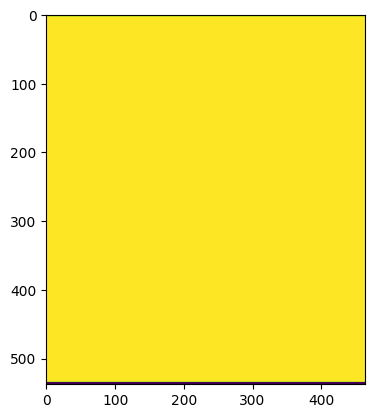

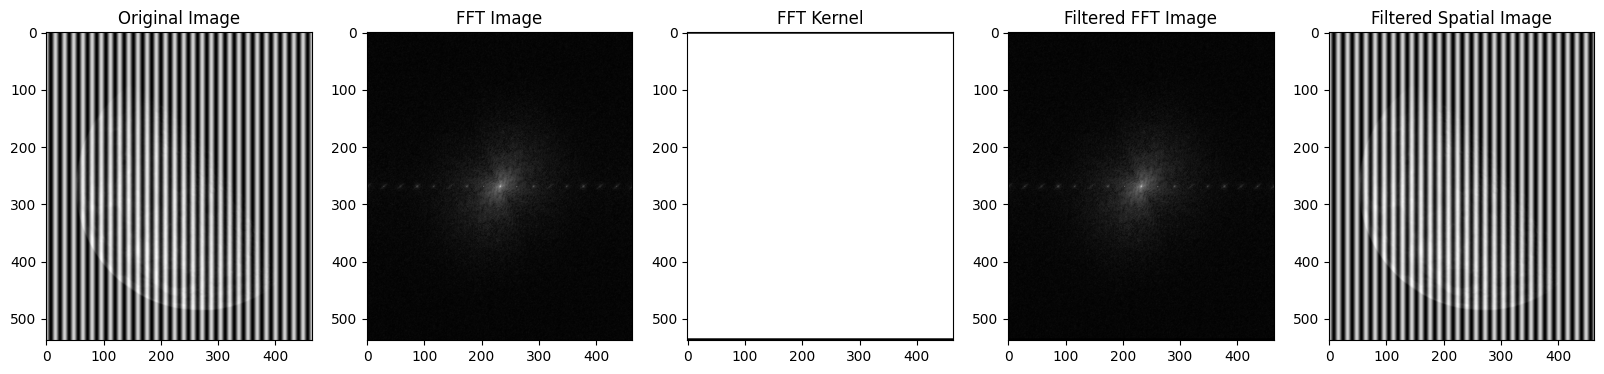

In [8]:
if __name__ == "__main__":
    # Changing this code should not be needed!
    
    impath = os.path.join("images", "noisy_moon.png")
    im = utils.read_im(impath)

    kernel = create_kernel(im)     
    #plt.imshow(kernel)
    # Note that this function is from your own implementation of convolve_im_freq from freq_1.ipynb
    im_filtered = convolve_im_freq(im, kernel, True) 
    
    utils.save_im("moon_filtered.png", utils.normalize(im_filtered))